In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import open3d as o3d
import pandas as pd
import os
import copy
from utility import listFiles, quickVizNumpy
from scipy.spatial.transform import Rotation as R
from numpy import cos, sin, sqrt, arctan2, array
import torch.nn as nn
from einops import rearrange
### fucking around
# from pretrain import loadDataFromRegisteredSlam, cart2sph, preProcess
from train import getSpacing, getTargetCumulativeTransmittance, getTargetTerminationDistribution


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [62]:
path = r'/home/ansonhon/anson/thesis/LiDAR_NeRF/datasets/training_cumulative/building.npy'
data_cumulative = np.load(path)


In [63]:
ray_origin = data_cumulative[:,0:3]
ray_direction = data_cumulative[:,3:6]
ray_distance = data_cumulative[:,6]
ray_distance = rearrange(ray_distance, 'a -> a 1')

In [124]:
import torch
import torch.nn as nn

# Define two probability distributions
# Tensor p and q are 1D tensors representing probability distributions
h_pred = torch.tensor([2.2523e-01 - 0.2, 4.5086e-02, 3.4559e-02, 2.3336e-02, 2.5034e-02, 1.0762e-02,
        1.7722e-02, 6.8988e-03, 1.1023e-02, 2.7386e-03, 8.8364e-03, 1.0213e-02,
        5.0265e-03, 1.0070e-02, 2.9175e-03, 9.0500e-03, 2.6145e-03, 8.9969e-03,
        3.0865e-03, 2.5114e-03, 5.1010e-03, 7.0914e-03, 1.0493e-03, 4.9464e-03,
        2.4952e-03, 4.2309e-03, 6.2509e-03, 1.5645e-04, 4.6447e-03, 3.5054e-03,
        3.3354e-03, 1.7782e-03, 4.8893e-03, 2.5938e-03, 3.5188e-03, 1.6341e-03,
        4.2589e-03, 2.6866e-03, 3.4943e-03, 2.7263e-03, 1.8788e-03, 1.6270e-03,
        4.2281e-03, 1.0700e-03, 4.5657e-03, 6.1262e-04, 5.0273e-03, 3.8864e-04,
        2.6450e-03, 3.9499e-03, 3.5786e-03 + 0.2, 1.3399e-03, 4.0289e-03, 1.5451e-04,
        2.8197e-03, 4.9536e-03, 7.7232e-04, 4.3798e-03, 1.6989e-03, 3.3942e-03,
        1.5410e-03, 2.9280e-03, 1.3904e-03, 2.6727e-03, 2.8807e-03, 3.5367e-03,
        1.9866e-03, 1.5870e-03, 4.5568e-03, 2.2724e-03, 3.0935e-03, 6.1459e-04,
        2.6093e-03, 5.1167e-03, 5.9625e-04, 4.6023e-03, 2.2147e-03, 1.0077e-03,
        5.0860e-03, 1.3702e-03, 3.7740e-03, 3.7969e-03, 1.1750e-03, 5.4617e-03,
        3.4450e-03, 1.9407e-03, 2.8735e-03, 4.1556e-03, 3.7211e-03, 7.1963e-03,
        1.1907e-03, 7.2899e-03, 4.2661e-03, 5.4982e-03, 1.2092e-02, 7.8384e-03,
        6.6398e-03, 1.7993e-02, 5.8207e-02, 2.0057e-01], dtype=torch.float32)
h_target = torch.tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7765e-07, 3.9404e-07,
        1.3416e-06, 1.5681e-06, 4.0253e-06, 2.0961e-06, 8.0597e-06, 1.6390e-05,
        1.6193e-05, 4.5069e-05, 2.5389e-05, 9.6322e-05, 5.0715e-05, 2.0757e-04,
        1.3084e-04, 1.3104e-04, 3.2445e-04, 6.3441e-04, 1.5424e-04, 7.9333e-04,
        5.9087e-04, 1.1787e-03, 2.4103e-03, 9.4822e-05, 2.8822e-03, 3.0277e-03,
        3.6797e-03, 2.5029e-03, 7.9002e-03, 5.8540e-03, 9.5507e-03, 5.6511e-03,
        1.6448e-02, 1.3810e-02, 2.1409e-02, 2.0736e-02, 1.6739e-02, 1.6160e-02,
        4.6222e-02, 1.3896e-02, 6.0538e-02, 9.5904e-03, 8.1612e-02, 7.1224e-03,
        4.9119e-02, 7.4014e-02, 6.8407e-02, 2.4523e-02, 7.2440e-02, 2.4901e-03,
        4.5382e-02, 7.5084e-02, 9.6141e-03, 5.2958e-02, 1.6175e-02, 2.9708e-02,
        1.1291e-02, 1.9712e-02, 7.6220e-03, 1.3216e-02, 1.1624e-02, 1.1694e-02,
        4.9087e-03, 3.3580e-03, 8.5700e-03, 2.9584e-03, 3.2854e-03, 4.9080e-04,
        1.9602e-03, 3.1383e-03, 2.3999e-04, 1.7533e-03, 5.3250e-04, 1.9147e-04,
        8.6806e-04, 1.3878e-04, 3.3336e-04, 2.2736e-04, 4.7121e-05, 1.9639e-04,
        6.4731e-05, 2.6409e-05, 3.1606e-05, 3.1687e-05, 1.7296e-05, 2.1487e-05,
        1.3050e-06, 6.8373e-06, 1.4835e-06, 1.0517e-06, 1.0226e-06, 9.8873e-08,
        2.5554e-08, 2.3212e-08, 2.8600e-09, 0.0000e+00], dtype=torch.float32)

# Ensure that p and q are normalized to represent probability distributions
# print(h_target.sum())
# h_pred = h_pred / h_pred.sum()
# h_target = h_target / h_target.sum()
# Define the KL Divergence loss function
kl_div_loss = nn.KLDivLoss(reduction = 'batchmean')

# Calculate the KL divergence
kl_div = kl_div_loss(h_pred.log(), h_target)

print(f"KL Divergence: {kl_div.item()}")


KL Divergence: 0.02077440917491913


In [141]:
a = torch.tensor([0.03, 0.02, 0.9, 0.9, 0.9])
b = torch.tensor([0, 0, 0.5, 1, 1])

BCE_loss = nn.BCELoss()
BCE_loss(a,b)


tensor(0.2931)

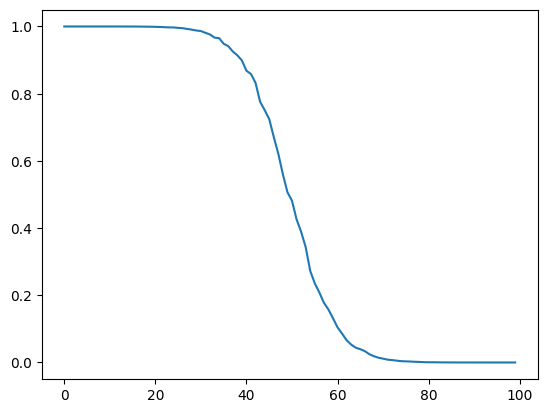

In [4]:
x = np.array([1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 9.9999e-01, 9.9998e-01, 9.9997e-01,
        9.9995e-01, 9.9990e-01, 9.9985e-01, 9.9985e-01, 9.9977e-01, 9.9956e-01,
        9.9945e-01, 9.9928e-01, 9.9895e-01, 9.9853e-01, 9.9796e-01, 9.9724e-01,
        9.9709e-01, 9.9586e-01, 9.9487e-01, 9.9265e-01, 9.9056e-01, 9.8805e-01,
        9.8639e-01, 9.8103e-01, 9.7621e-01, 9.6684e-01, 9.6518e-01, 9.4854e-01,
        9.4154e-01, 9.2549e-01, 9.1422e-01, 8.9896e-01, 8.6830e-01, 8.5838e-01,
        8.3196e-01, 7.7583e-01, 7.5107e-01, 7.2449e-01, 6.7105e-01, 6.2090e-01,
        5.5989e-01, 5.0679e-01, 4.8118e-01, 4.2613e-01, 3.8894e-01, 3.4350e-01,
        2.7259e-01, 2.3568e-01, 2.0845e-01, 1.7782e-01, 1.5757e-01, 1.3167e-01,
        1.0446e-01, 8.5785e-02, 6.6120e-02, 5.3085e-02, 4.4003e-02, 3.9595e-02,
        3.3712e-02, 2.4469e-02, 1.8504e-02, 1.4175e-02, 1.1343e-02, 8.4108e-03,
        7.1440e-03, 5.3640e-03, 3.8850e-03, 3.3160e-03, 2.8080e-03, 2.0700e-03,
        1.6065e-03, 9.1468e-04, 6.5227e-04, 6.1510e-04, 4.4576e-04, 2.4320e-04,
        2.0455e-04, 1.4801e-04, 9.3901e-05, 4.2646e-05, 3.4530e-05, 1.4525e-05,
        1.3218e-05, 5.0550e-06, 2.3407e-06, 1.6430e-06, 3.8642e-07, 1.4675e-07,
        2.6563e-08, 6.0454e-09, 3.7100e-10, 1.0050e-15])

plt.plot(x)
plt.show()

In [2]:
torch.cuda.is_available()

True